# Analyse des données CO₂ — 

Ce notebook réalise les étapes demandées  :
- **Analyser des données CO₂** (chargement, dictionnaire des variables, statistiques descriptives)  
- **Comprendre les types/variables** (schéma des données)  
- **Suggérer et produire des graphiques utiles** pour la décision  
- **Moyenne mobile (window averaging)**  
- **Calculer les variations et les variations de variations** (Δ et Δ²)  
- **(Optionnel) Carte** : si `pygal` est disponible, on génère une carte monde au format SVG (aucune erreur si absent).  

Données utilisées : `co2_data_synthetic.csv` (enregistré le 2025-09-02).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

DATA_PATH = Path('co2_data_synthetic.csv')
df = pd.read_csv(DATA_PATH)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'co2_data_synthetic.csv'

## 1) Dictionnaire des variables et types

In [ ]:
schema = pd.DataFrame({
    'variable': df.columns,
    'dtype': [str(t) for t in df.dtypes],
    'description': [
        'Année (AAAA)',
        'Nom du pays',
        'Code ISO-3',
        'Région macro',
        'Émissions de CO₂ (Mt)',
        'Population (millions)',
        'PIB (milliards USD)'
    ]
})
schema

,variable,dtype,description
0,year,int64,Année (AAAA)
1,country,object,Nom du pays
2,iso3,object,Code ISO-3
3,region,object,Région macro
4,co2_mt,float64,Émissions de CO₂ (Mt)
5,population_m,float64,Population (millions)
6,gdp_billion_usd,float64,PIB (milliards USD)


## 2) Indicateurs dérivés et statistiques descriptives

In [ ]:
df = df.copy()
df['co2_per_capita_t'] = (df['co2_mt']*1e6) / (df['population_m']*1e6)  # tonnes par habitant
df['co2_per_capita_t'] = df['co2_per_capita_t'].round(2)
desc = df[['co2_mt','co2_per_capita_t','gdp_billion_usd','population_m']].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
co2_mt,192.0,1790.436458,2039.690227,328.00,421.8250,681.250,2231.9500,6658.70
co2_per_capita_t,192.0,8.718125,6.271349,0.87,2.9275,7.915,12.0925,19.85
gdp_billion_usd,192.0,3034.017708,4741.275533,136.90,653.3250,1201.450,2411.0000,19768.10
population_m,192.0,397.188385,498.160311,19.01,57.3325,132.660,503.2650,1455.88


## 3) Graphiques utiles pour la décision
Recommandations :
- **Séries historiques** par pays (niveau et par habitant) pour repérer des tendances et ruptures.
- **Comparaisons régionales** (médianes par région).
- **Relation CO₂–PIB** (cloud de points, élasticité).

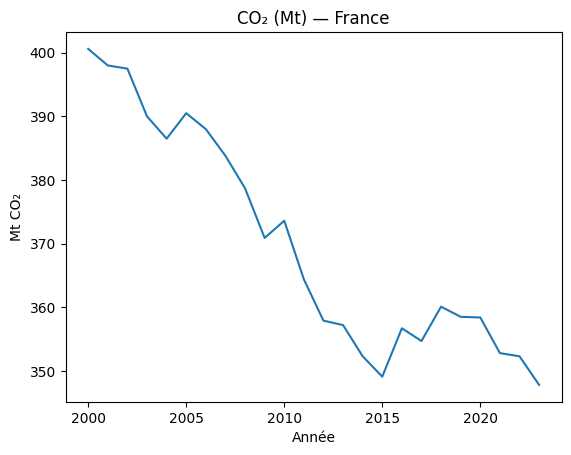

In [ ]:
# 3.a) Série historique — CO₂ niveau (exemple : France)
country = 'France'
sub = df[df['country']==country].sort_values('year')
plt.figure()
plt.plot(sub['year'], sub['co2_mt'])
plt.title(f'CO₂ (Mt) — {country}')
plt.xlabel('Année')
plt.ylabel('Mt CO₂')
plt.show()

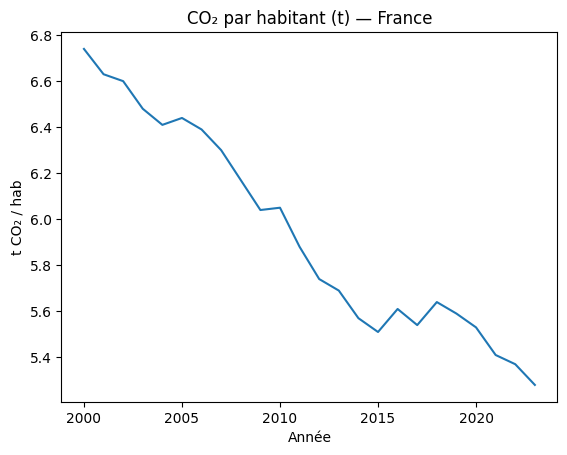

In [ ]:
# 3.b) Série historique — CO₂ par habitant (exemple : France)
plt.figure()
plt.plot(sub['year'], sub['co2_per_capita_t'])
plt.title(f'CO₂ par habitant (t) — {country}')
plt.xlabel('Année')
plt.ylabel('t CO₂ / hab')
plt.show()

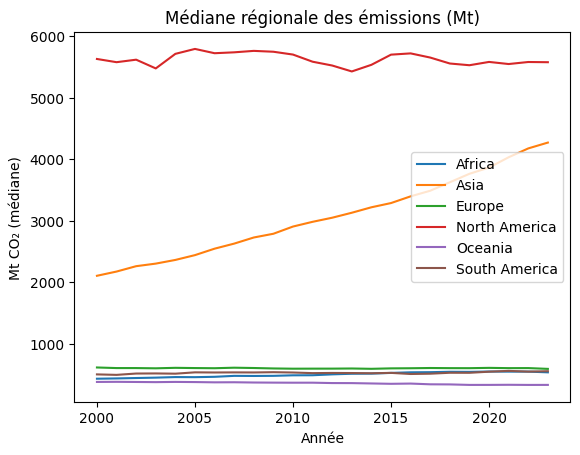

In [ ]:
# 3.c) Comparaison régionale – médianes CO₂ (Mt) par année
median_reg = df.groupby(['year','region'])['co2_mt'].median().reset_index()
pivot = median_reg.pivot(index='year', columns='region', values='co2_mt')
plt.figure()
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)
plt.title('Médiane régionale des émissions (Mt)')
plt.xlabel('Année')
plt.ylabel('Mt CO₂ (médiane)')
plt.legend()
plt.show()

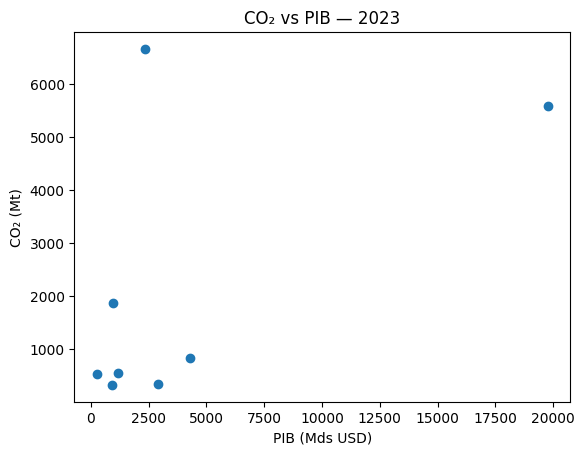

In [ ]:
# 3.d) Relation CO₂–PIB (nuage de points, année récente)
latest_year = df['year'].max()
lat = df[df['year']==latest_year]
plt.figure()
plt.scatter(lat['gdp_billion_usd'], lat['co2_mt'])
plt.title(f'CO₂ vs PIB — {latest_year}')
plt.xlabel('PIB (Mds USD)')
plt.ylabel('CO₂ (Mt)')
plt.show()

## 4) Moyenne mobile (window averaging)
On calcule une **moyenne mobile centrée** (fenêtre = 3 ans) pour lisser les séries.

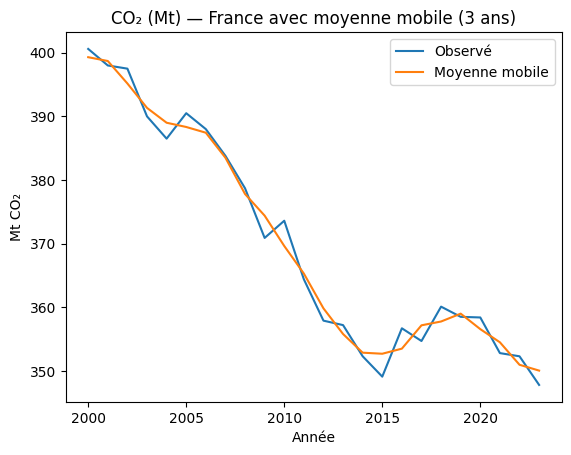

,year,co2_mt,co2_ma
0,2000,400.6,399.300000
1,2001,398.0,398.700000
2,2002,397.5,395.166667
3,2003,390.0,391.333333
4,2004,386.5,389.000000


In [ ]:
def rolling_ma(series, window=3):
    return series.rolling(window=window, center=True, min_periods=1).mean()

sub = df[df['country']==country].sort_values('year')
sub['co2_ma'] = rolling_ma(sub['co2_mt'], window=3)
plt.figure()
plt.plot(sub['year'], sub['co2_mt'], label='Observé')
plt.plot(sub['year'], sub['co2_ma'], label='Moyenne mobile')
plt.title(f'CO₂ (Mt) — {country} avec moyenne mobile (3 ans)')
plt.xlabel('Année')
plt.ylabel('Mt CO₂')
plt.legend()
plt.show()
sub[['year','co2_mt','co2_ma']].head()

## 5) Variations et variations de variations
On calcule :
- **Δ (différence annuelle)** et **Δ% (taux de croissance)**, 
- **Δ²** (variation des variations, i.e., seconde différence).

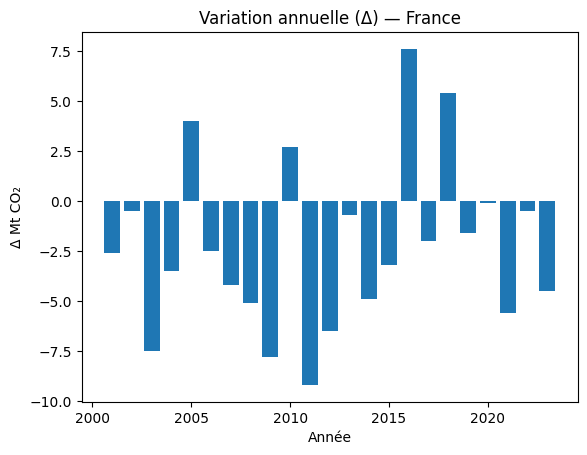

,year,co2_mt,delta,pct_change,delta2
0,2000,400.6,NaN,NaN,NaN
1,2001,398.0,-2.6,-0.649026,NaN
2,2002,397.5,-0.5,-0.125628,2.1
3,2003,390.0,-7.5,-1.886792,-7.0
4,2004,386.5,-3.5,-0.897436,4.0


In [ ]:
sub = df[df['country']==country].sort_values('year').reset_index(drop=True)
sub['delta'] = sub['co2_mt'].diff()
sub['pct_change'] = sub['co2_mt'].pct_change()*100
sub['delta2'] = sub['delta'].diff()
plt.figure()
plt.bar(sub['year'], sub['delta'])
plt.title(f'Variation annuelle (Δ) — {country}')
plt.xlabel('Année')
plt.ylabel('Δ Mt CO₂')
plt.show()
sub[['year','co2_mt','delta','pct_change','delta2']].head()